# NB4: performs alignment (registration) and decay correction of sequential tumor slices
- inputs: folder of non-aligned activity images; time correction parameter
    - we will use the output of NB3 (sequential preprocessing) as the example.
- output: folder of aligned (and decay corrected) activity images

In [1]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

import pystackreg
from pystackreg import StackReg

%load_ext autoreload
%autoreload 2
from iqid import helper as iq
from iqid import process_object as po
from iqid import align

## Parameters and corrections

In [3]:
imdir = os.path.join("data_sample", "2_sample", "robin_test", "mBq_images")

In [4]:
t_half_life = 9.92 * 24 * 3600 # updated value (2019) from NNDC for Ac-225

In [5]:
# decay correction times
d, h, m = np.genfromtxt(os.path.join("data_sample", "2_sample", 'correction_times.csv'),
                                  delimiter=',',
                                  skip_header=1,
                                  usecols=(7, 8, 9),
                                  unpack=True)

s_corr = 24 * 3600 * d + 3600 * h + 60 * m

### Registration

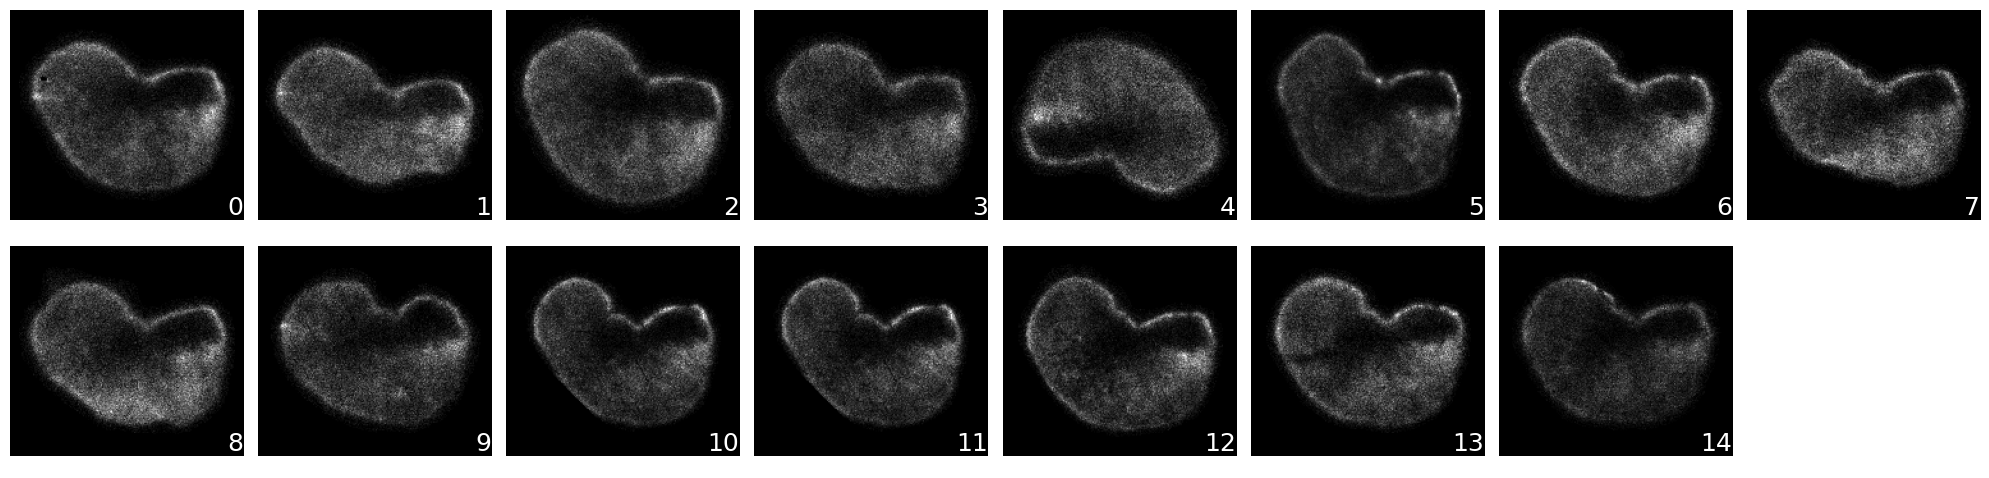

In [6]:
imstack = align.assemble_stack(imdir, fformat='tif', pad=True)
exclude_list = np.array([11])
imstack = align.ignore_images(imstack, exclude_list, pad='backwards')
iq.plot_sequence(imstack, figsize=(20,5))

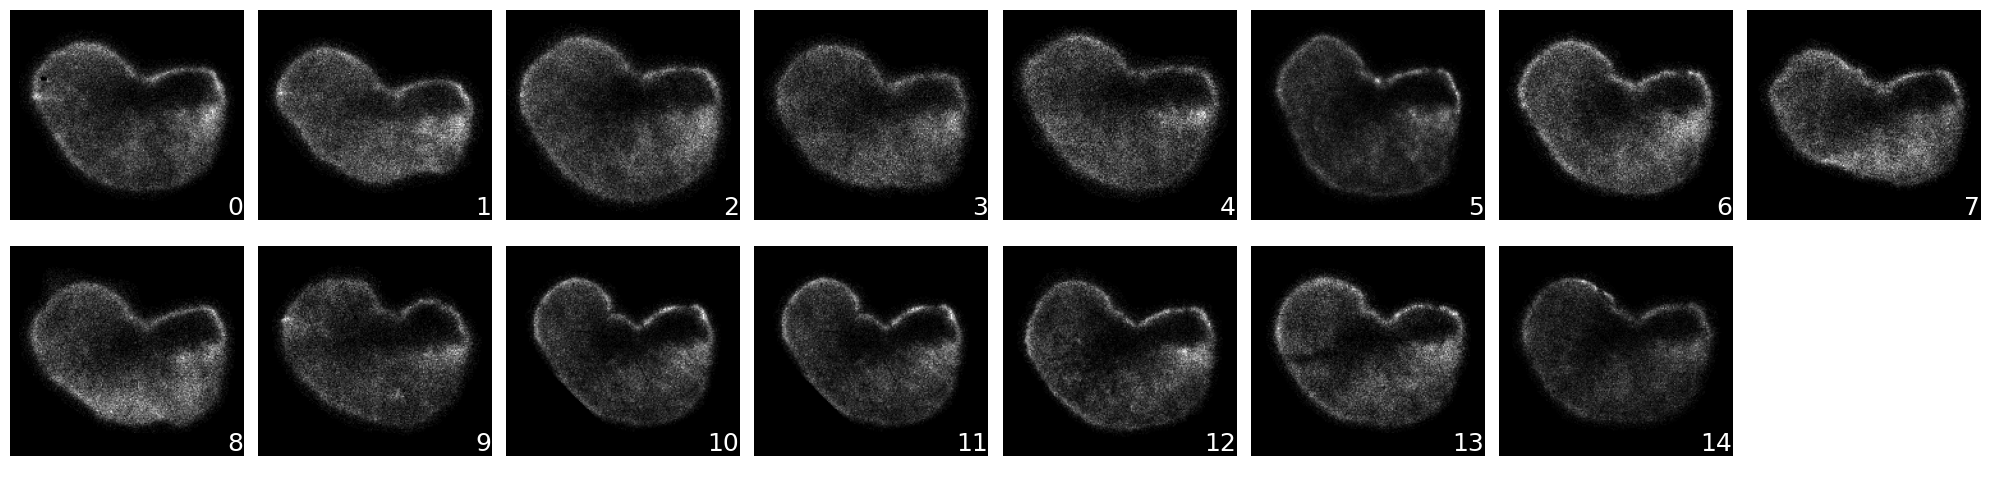

In [7]:
rot = align.coarse_stack(imstack, deg=2, avg_over=2)
iq.plot_sequence(rot, figsize=(20,5))

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 35.75it/s]


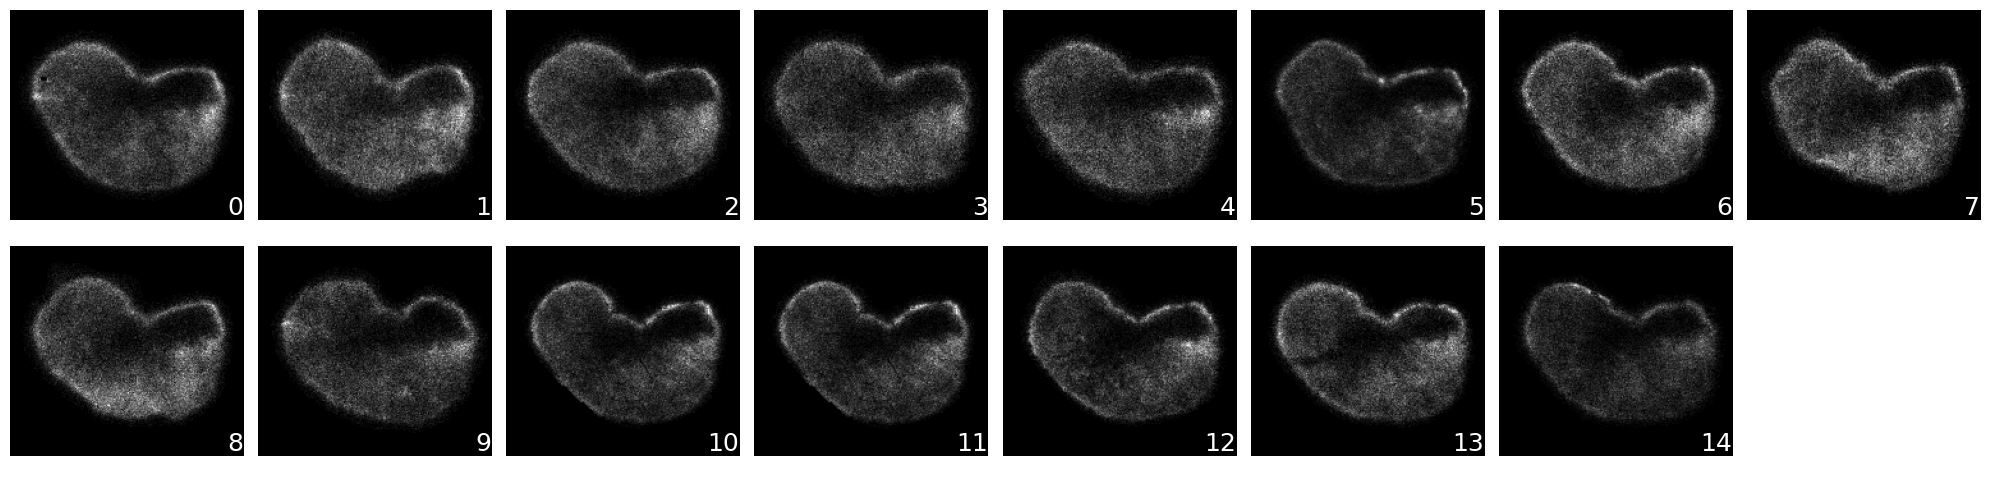

In [8]:
sr = StackReg(StackReg.AFFINE)
tmat = sr.register_stack(rot, reference='previous', verbose=True) 
reg = align.transform_stack(rot, tmat).clip(min=0)
iq.plot_sequence(reg, figsize=(20,5))

The largest amount of shear in this stack is 0.07.
The largest amount of zoom in this stack is 10.7%.
Small-value errors result in summed activity difference of -0.82%.


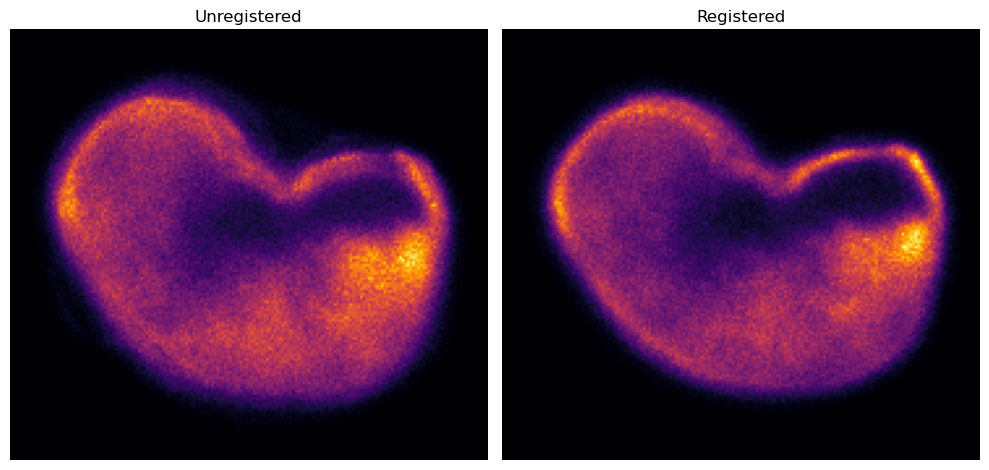

-0.008183488077795302

In [9]:
align.quantify_err(imstack, reg, tmat)

### Activity correction and save

In [10]:
ss_idx = 4
print(d[ss_idx].astype(int), 'd', 
      h[ss_idx].astype(int), 'h',
      m[ss_idx].astype(int), 'm')

reg_corr = reg * np.exp(np.log(2)*s_corr[ss_idx]/t_half_life) # mBq
align.save_imbatch(reg_corr, os.path.join(imdir, '..', 'mBq_corrected'), prefix='mBq_corr')

2 d 2 h 50 m


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 891.89it/s]
